---
# Create graphic for study area, Vessel Time Exposures (VTE) and comparing oil spills files
---

The monte carlo runs were completed on Compute Canada's supercomputer, `Graham` and this code is intended to be used on that system.  It requires initialization of a Virtual Environment.  See `/home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt`.

First initiate a compute node (no heavy-lifting in this example) with: 
```
salloc --time=1:00:00 --ntasks=1 --cpus-per-task=1 --mem-per-cpu=1024M --account=rrg-allen
```
Activate `VENV` with:
```
module load python/3.8.2
source ~/venvs/jupyter/bin/activate
```
Deactivate `VENV` with:
```
deactivate
```
If the `jupyter` `VENV` is not yet setup, install it with:
```
module load python/3.8.2
python3 -m virtualenv --no-download ~/venvs/jupyter
source ~/venvs/jupyter/bin/activate
python3 -m pip install --no-index --upgrade pip
python3 -m pip install -r /home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt
```

This environment is setup to allow user to initiate a remote window using:
```
jupyter lab --no-browser --ip $(hostname -f)
```

In [1]:
import os
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
import rioxarray
from cmocean import cm as cmo
from glob import glob
from cartopy import crs,feature
import matplotlib as mpl
from matplotlib import pyplot as plt, patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
#from salishsea_tools import geo_tools, tidetools

In [2]:
graphics_dir = Path('/ocean/rmueller/MIDOSS/graphics/')
geotiff_directory = Path('/data/MIDOSS/geotiffs')
# larger, presentation-size graphics require different xy text specifications
graphics_size='large'
if graphics_size=='large':
    # graphics style
    plt.style.use(r"../../style_templates/general_matplotlibrc.template")

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3

In [3]:
mask = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
spills = pandas.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

# Load ETOPO1 data set
topo = xarray.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ETOPO1_Bed_g_gmt4.grd')

# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
#lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]
tmask = mask.tmask[0, 0, ...].values

In [4]:
# Annotations
if graphics_size=='large':
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.43, 0.8), 'r':-60, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.2), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.81, 0.2), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.45, 0.28), 'r': -20, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.11, 0.717), 'r': -20, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.735, 0.585), 'r':   0, 'wt': 'bold', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]
    annotations_fine = [
        {'name': '1', 'xy': (0.622,0.25), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '2', 'xy': (0.29,0.39), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '3', 'xy': (0.477,0.43), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '4', 'xy': (0.345,0.57), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '5', 'xy': (0.75,0.445), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
    ]
else:
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.41, 0.78), 'r':   -60, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.200), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.810, 0.180), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.475, 0.26), 'r': -17, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.11, 0.717), 'r': -20, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.75, 0.6), 'r':   0, 'wt': 'bold', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]

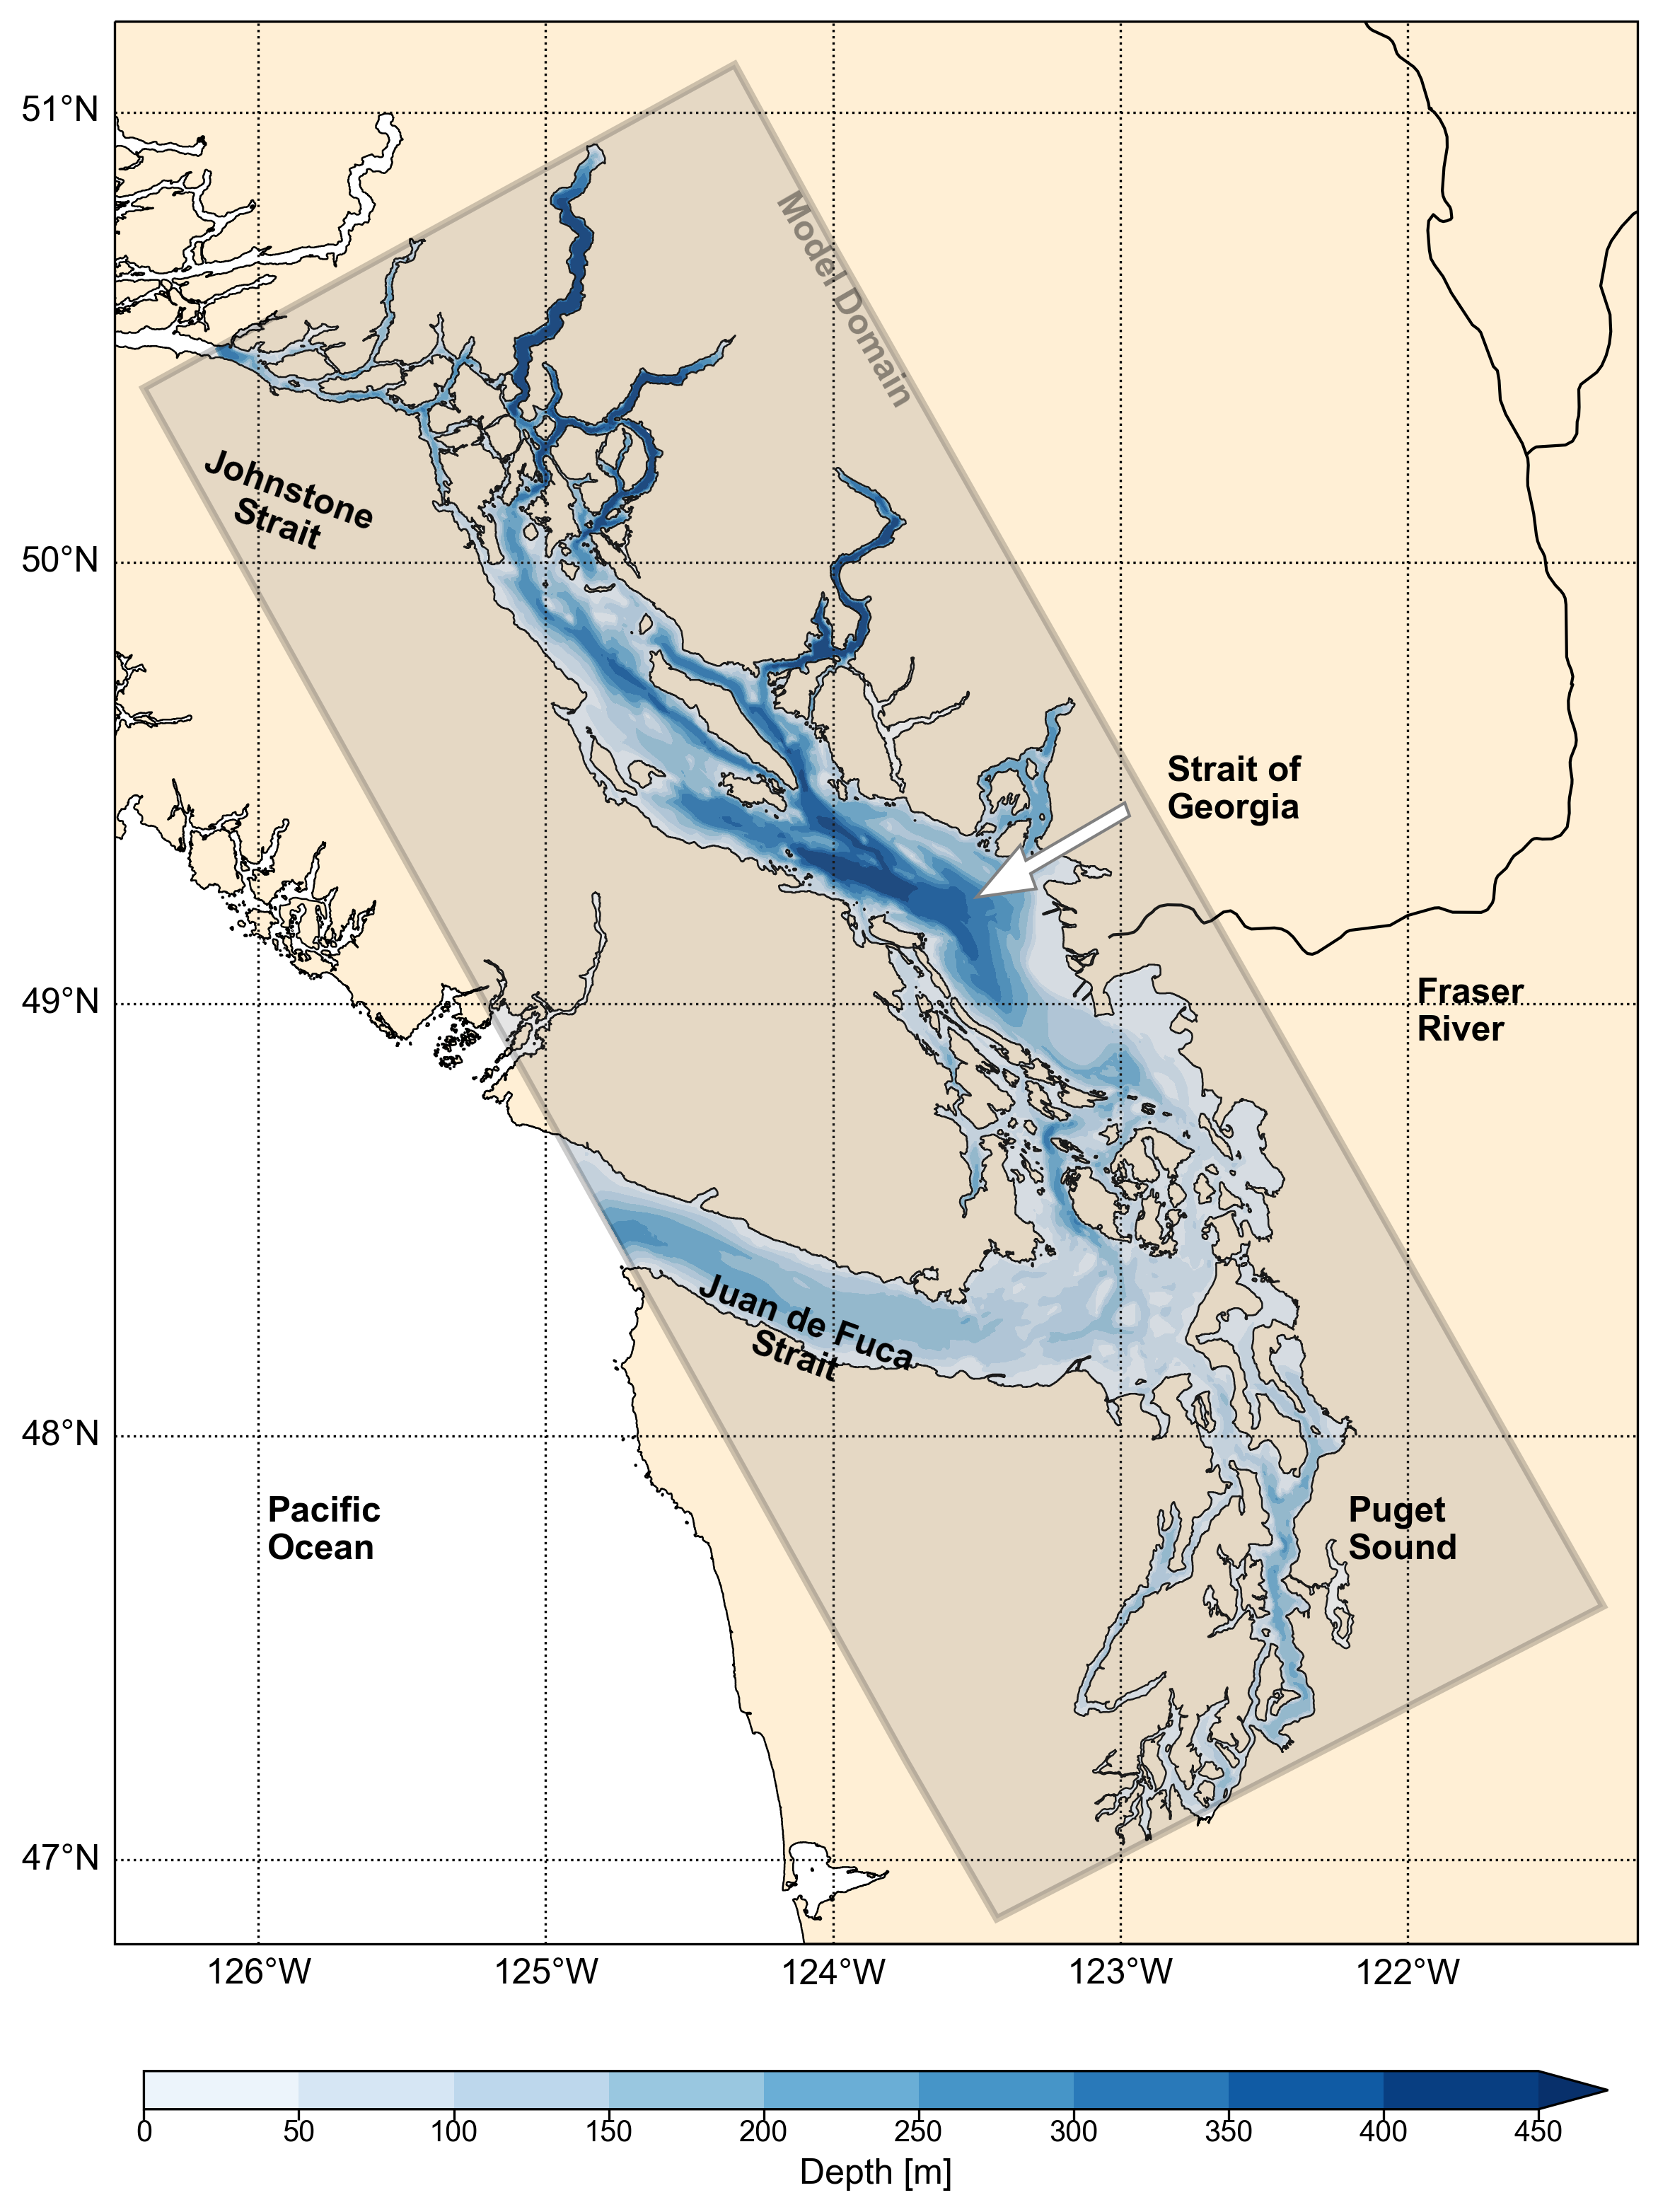

In [5]:
# The code for this figure is a modified version of code from Ben Moore-Maley
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(30, 12))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
#ax.add_patch(patches.Rectangle((-125.3, 49.1), 1.5, 1.2, fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))

# Annotations
for ann in annotations_coarse:
    if ann['alpha'] is not None:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha'],
                alpha=ann['alpha']
               )
    else:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha']
               )
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.0075, head_width=0.025, edgecolor='grey', facecolor='white', transform=ax.transAxes, zorder=10)

# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')
#plt.savefig(graphics_dir/'SSC_model_domain.png')

### Boundary boxes for regional analyses

In [6]:
domain_box

array([[-123.42943248,   46.85966577],
       [-121.31835518,   47.60092035],
       [-124.34198758,   51.10480224],
       [-126.40028872,   50.38992717]])

In [7]:
## Create masks
# order: (lower-left, lower-right, upper-right, upper-left)
jdf_box = numpy.array([
    [-125,48.079463],[-123.6,48.079463],
    [-123.6,48.7],[-125,48.7]
])
gulfIsland_box = numpy.array([
    [-123.661884,48.693059],[-123.044003,48.693059],[
    -123.044003,48.953784],[-123.661884,48.953784]
]) 
pugetSound_box = numpy.array([
    [-123.25,47],[-122,47],
    [-122,48.064543],[-123.25,48.064543]
])
cowichan_box = numpy.array([
    [-124,48.7],[-123,48.7],
    [-123,49.25],[-124,49.25]
])
lummi_box = numpy.array([
    [-122.72,48.64],[-122.54,48.64],
    [-122.54,48.8],[-122.72,48.8]
])
sog_box = numpy.array([
    [-124.7,49],[-122.6849,49],
    [-122.68,49.46],[-124.7,49.46]
])

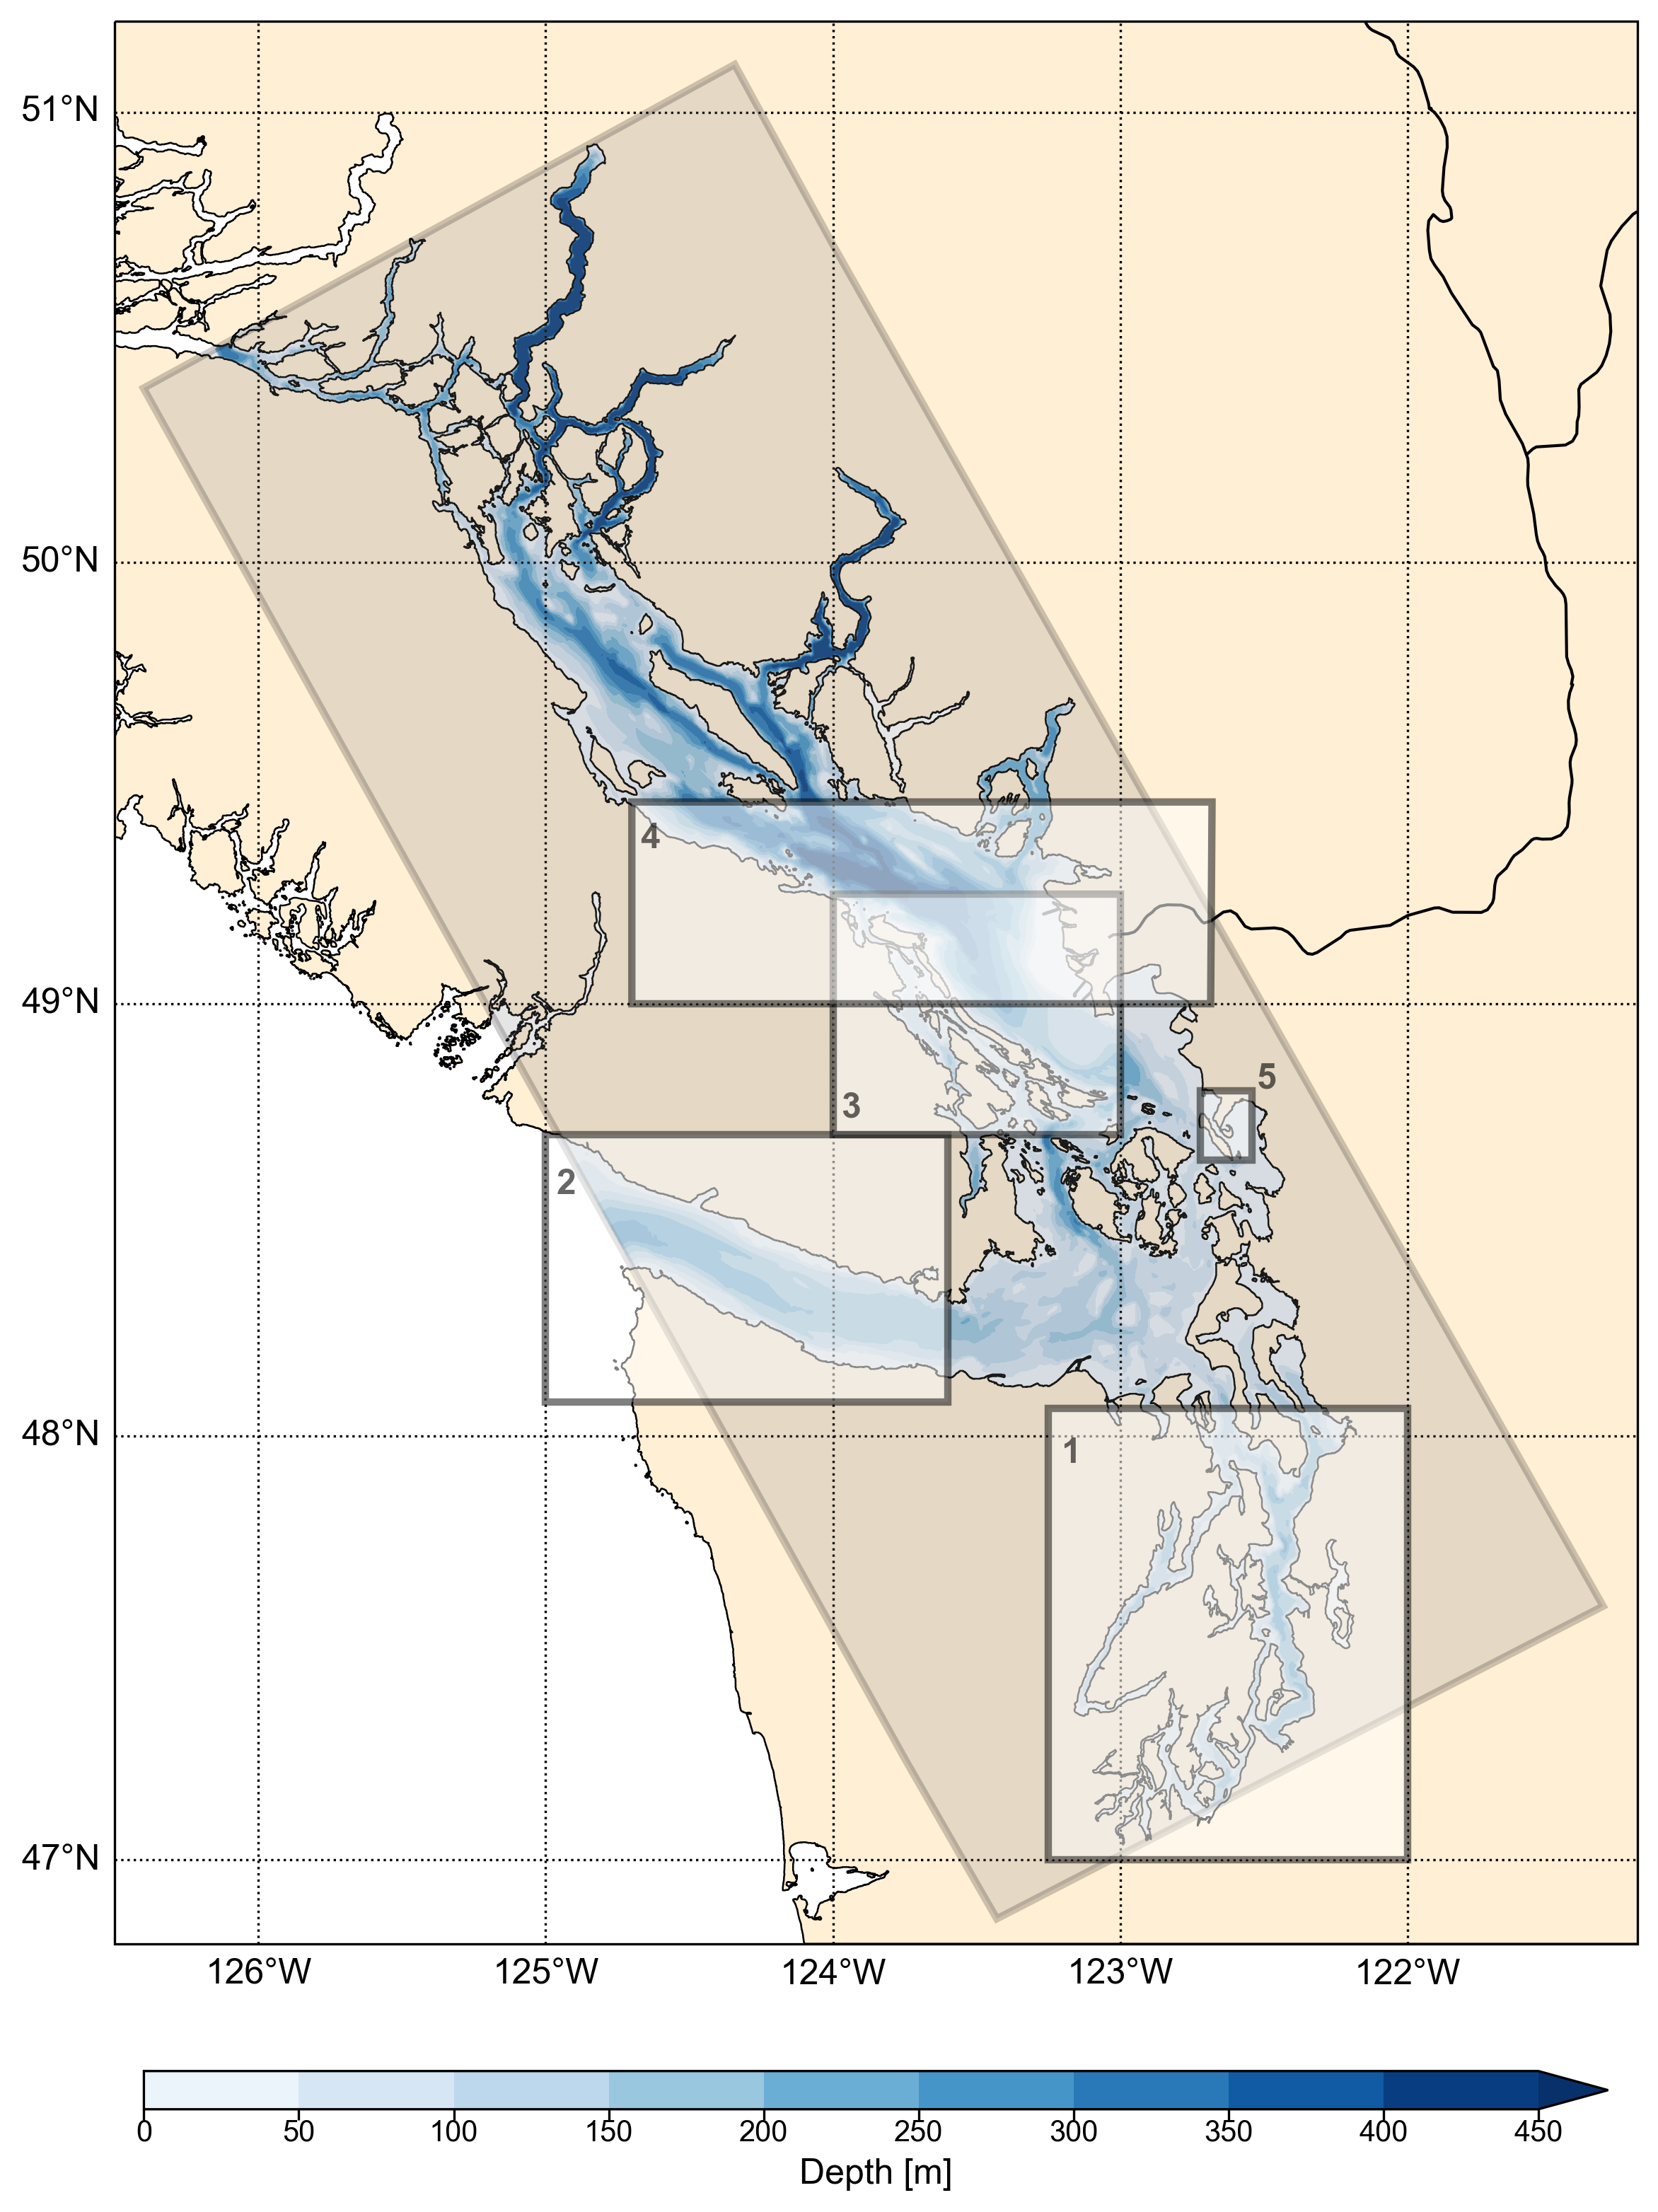

In [8]:
# The code for this figure is a modified version of code from Ben Moore-Maley
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(30, 12))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
ax.add_patch(patches.Polygon(jdf_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))
ax.add_patch(patches.Polygon(pugetSound_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))
ax.add_patch(patches.Polygon(cowichan_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))
ax.add_patch(patches.Polygon(lummi_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))
ax.add_patch(patches.Polygon(sog_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))

# Annotations
for ann in annotations_fine:
    if ann['alpha'] is not None:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha'],
                alpha=ann['alpha']
               )
# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')
#plt.savefig(graphics_dir/'SSC_model_domain_withBoundaries.png')

### Plot VTE

In [9]:
from array import *
ship_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo',
    'ferry',  
    'other'
]
months = array('i',range(1,13))
vte={}
max_vte=[]

# Add VTE across all months in 2018
for ship in ship_types:
    for month in months:
        if month==1:
            vte[ship] = rioxarray.open_rasterio(
                geotiff_directory/f"{ship}_2018_{month:02.0f}.tif",
                masked=True
            )
            # store max value across all vessels
            max_val = vte[ship][0].max().values.item()
        else:

            vte[ship] += rioxarray.open_rasterio(
                geotiff_directory/f"{ship}_2018_{month:02.0f}.tif",
                masked=True
            )
            max_val = max(max_val,vte[ship][0].max().values.item())
        vte[ship] = vte[ship].where(vte[ship]!=0)
        #da = da.where(da!=da.attrs['_FillValue'])
    max_vte.append(max_val)

In [10]:
numpy.max(max_vte)

2629.939208984375

In [11]:
#da = rioxarray.open_rasterio(geotiff_directory/"all_2018_01.tif",masked=True)
ship = 'cargo'
# create plotting mesh and set all zero and _FillValues to NaN 
x, y = numpy.meshgrid(vte[ship].x, vte[ship].y)
# set the interval between levels
step = (
    numpy.ceil(numpy.log10(numpy.max(max_vte))) - numpy.floor(numpy.log10(0.01)))/50
# graphic levels
lev_exp = numpy.arange(
    numpy.floor(numpy.log10(0.01)),
    numpy.ceil(numpy.log10(1e3)),
    step
)
# for log-scale plot
levs = numpy.power(10, lev_exp)

In [12]:
## single VTE map
# fig,ax = plt.subplots(
#     1, 1, figsize=(6, 3), 
#     subplot_kw={"projection": rotated_crs, 
#                 "facecolor": "white"}
# )
# ax.set_extent([-124, -123.75, lat.min()-0.15, lat.max()])
# ax.add_feature(feature.GSHHSFeature(
#     'full', edgecolor='k', linewidth=lw, facecolor='papayawhip'))
# ax.add_feature(feature.NaturalEarthFeature(
#     category='physical', name='rivers_lake_centerlines',
#     scale='10m', facecolor='none', edgecolor='k',
#     linewidth=lw
# ))

# ax.coastlines(resolution='10m', alpha=0.1)
# C=ax.contourf(x, y, 
#             vte[ship][0],
#             levs,
#             cmap=cmo.cm.Blues, 
#             norm=colors.LogNorm(),
#             transform=plain_crs)

# cb = fig.colorbar(C, ax=ax);
# cb.set_ticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
# cb.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
# # cb.ax.set_yticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
# plt.show()

### Show all

In [13]:
len(ship_types)

6

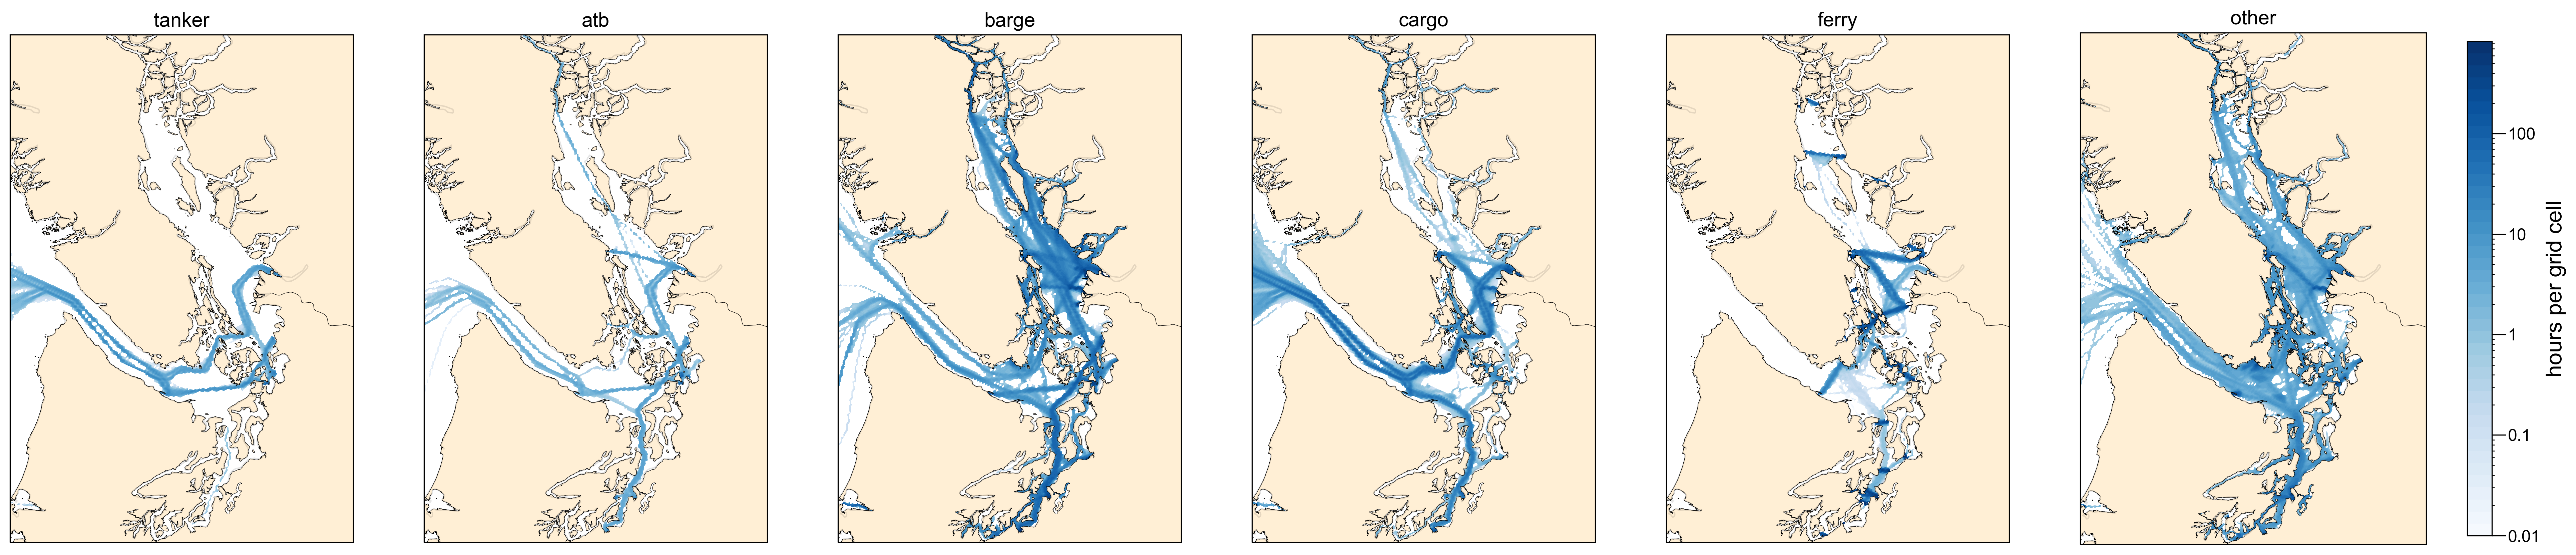

In [14]:
fig, ax = plt.subplots(1, len(ship_types), 
              figsize=(32, 10),
              subplot_kw={'projection': rotated_crs, 
                "facecolor": "white"},
              gridspec_kw={
                   'width_ratios': [1,1,1,1,1,1.2],
                   'height_ratios': [1]}
)

for idx,ship in enumerate(ship_types):
    ax[idx].set_extent([-124, -123.75, lat.min()-0.15, lat.max()])
    ax[idx].set_title(ship)
    ax[idx].add_feature(feature.GSHHSFeature(
        'full', edgecolor='k', linewidth=lw, facecolor='papayawhip'))
    ax[idx].add_feature(feature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines',
        scale='10m', facecolor='none', linewidth=lw, edgecolor='k',
    ))
    ax[idx].coastlines(resolution='10m', alpha=0.1)
    C=ax[idx].contourf(x, y, 
                vte[ship][0],
                levs,
                cmap=cmo.cm.Blues, 
                norm=colors.LogNorm(),
                transform=plain_crs)


cb = fig.colorbar(C, 
                  ax=ax[len(ship_types)-1], 
                  ticks=[1e-2,1e0,1e2],
                  fraction=0.06, pad=0.1
                 );
cb.set_ticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
cb.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
cb.ax.tick_params(labelsize=12)
cb.ax.tick_params(which='major', length=10, color='k') 
cb.set_label('hours per grid cell', fontsize = 16);
plt.savefig(graphics_dir/'ship_tracks/VTE_allTraffic_6panel.png')
plt.show()

### Previous code below

In [15]:
ssc_bathymetry = '/ocean/rmueller/SalishSeaCast/grid/bathymetry_201702.nc'
ssc_mask = '/ocean/rmueller/SalishSeaCast/grid/mesh_mask201702.nc'

fnames = [
    'Lagrangian_akns.dat',
    'Lagrangian_bunker.dat',
    'Lagrangian_dilbit.dat',
    'Lagrangian_diesel.dat',
    'Lagrangian_gas.dat',
    'Lagrangian_jet.dat',
    'Lagrangian_other.dat'
]
MIDOSSlabels=[
    'ANS',
    'Bunker-C',
    'Dilbit',
    'Diesel',
    'Diesel',
    'Diesel',
    'Bunker-C'
]

### Load 10,000 spills files on Salish

In [16]:
spills_dir_name = 'spill_files_091921'
# On Salish
data_directory = Path(f'/ocean/rmueller/MIDOSS/{spills_dir_name}')
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')
# Load Oil Attribution file 
oil_attribution_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
# create list of spill files to plot/evaluate
filenames = sorted(glob(os.path.join(data_directory,"*.csv")))

In [17]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pandas.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
         fnames, MIDOSSlabels
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pandas.concat([df_combined, df[index]])
    

0 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_1.csv
1 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_2.csv
2 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_3.csv
3 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_4.csv
4 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_5.csv
5 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_6.csv
6 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_7.csv
7 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_8.csv
8 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_9.csv


In [18]:
[*df]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [19]:
# load SSC grid and mask
bathy = xarray.open_dataset(ssc_bathymetry)
mask = xarray.open_dataset(ssc_mask)
# create mask for plotting...?
tmask = mask.tmask[0,0,:,:]

In [20]:
a_count={}
a_vol = {}

### Bin spills by number of spills and volume of spills for each 10,000 spills file

In [21]:
for index,fn in enumerate(filenames):
    print(index)
    # histogram by number of spills
    h_count,xe,ye = numpy.histogram2d(
        df[index].spill_lon, 
        df[index].spill_lat, 
        bins=100
    );
    # historgram by spill volume
    h_vol,xe,ye = numpy.histogram2d(
        df[index].spill_lon, 
        df[index].spill_lat, 
        weights = df[index].spill_volume,
        bins=100
    );
    # combine histrograms into 3D arrays
    a_count[index]=h_count
    a_vol[index]=h_vol
    if index == 0:
        count_hist_3d = a_count[0]
        vol_hist_3d = a_vol[0]
    else:
        count_hist_3d=numpy.dstack([count_hist_3d,h_count])
        vol_hist_3d=numpy.dstack([vol_hist_3d,h_vol])


0
1
2
3
4
5
6
7
8


In [22]:
count_hist_3d.shape

(100, 100, 9)

### Create 2d array with range of values across 10,000 spills files of:
- number of spills per histogram cell
- volume of oil spilled in histogram cells

In [23]:
count_hist_range = count_hist_3d.max(axis=2) - count_hist_3d.min(axis=2)
vol_hist_range = vol_hist_3d.max(axis=2) - vol_hist_3d.min(axis=2)

/tmp/ipykernel_19618/3043979606.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


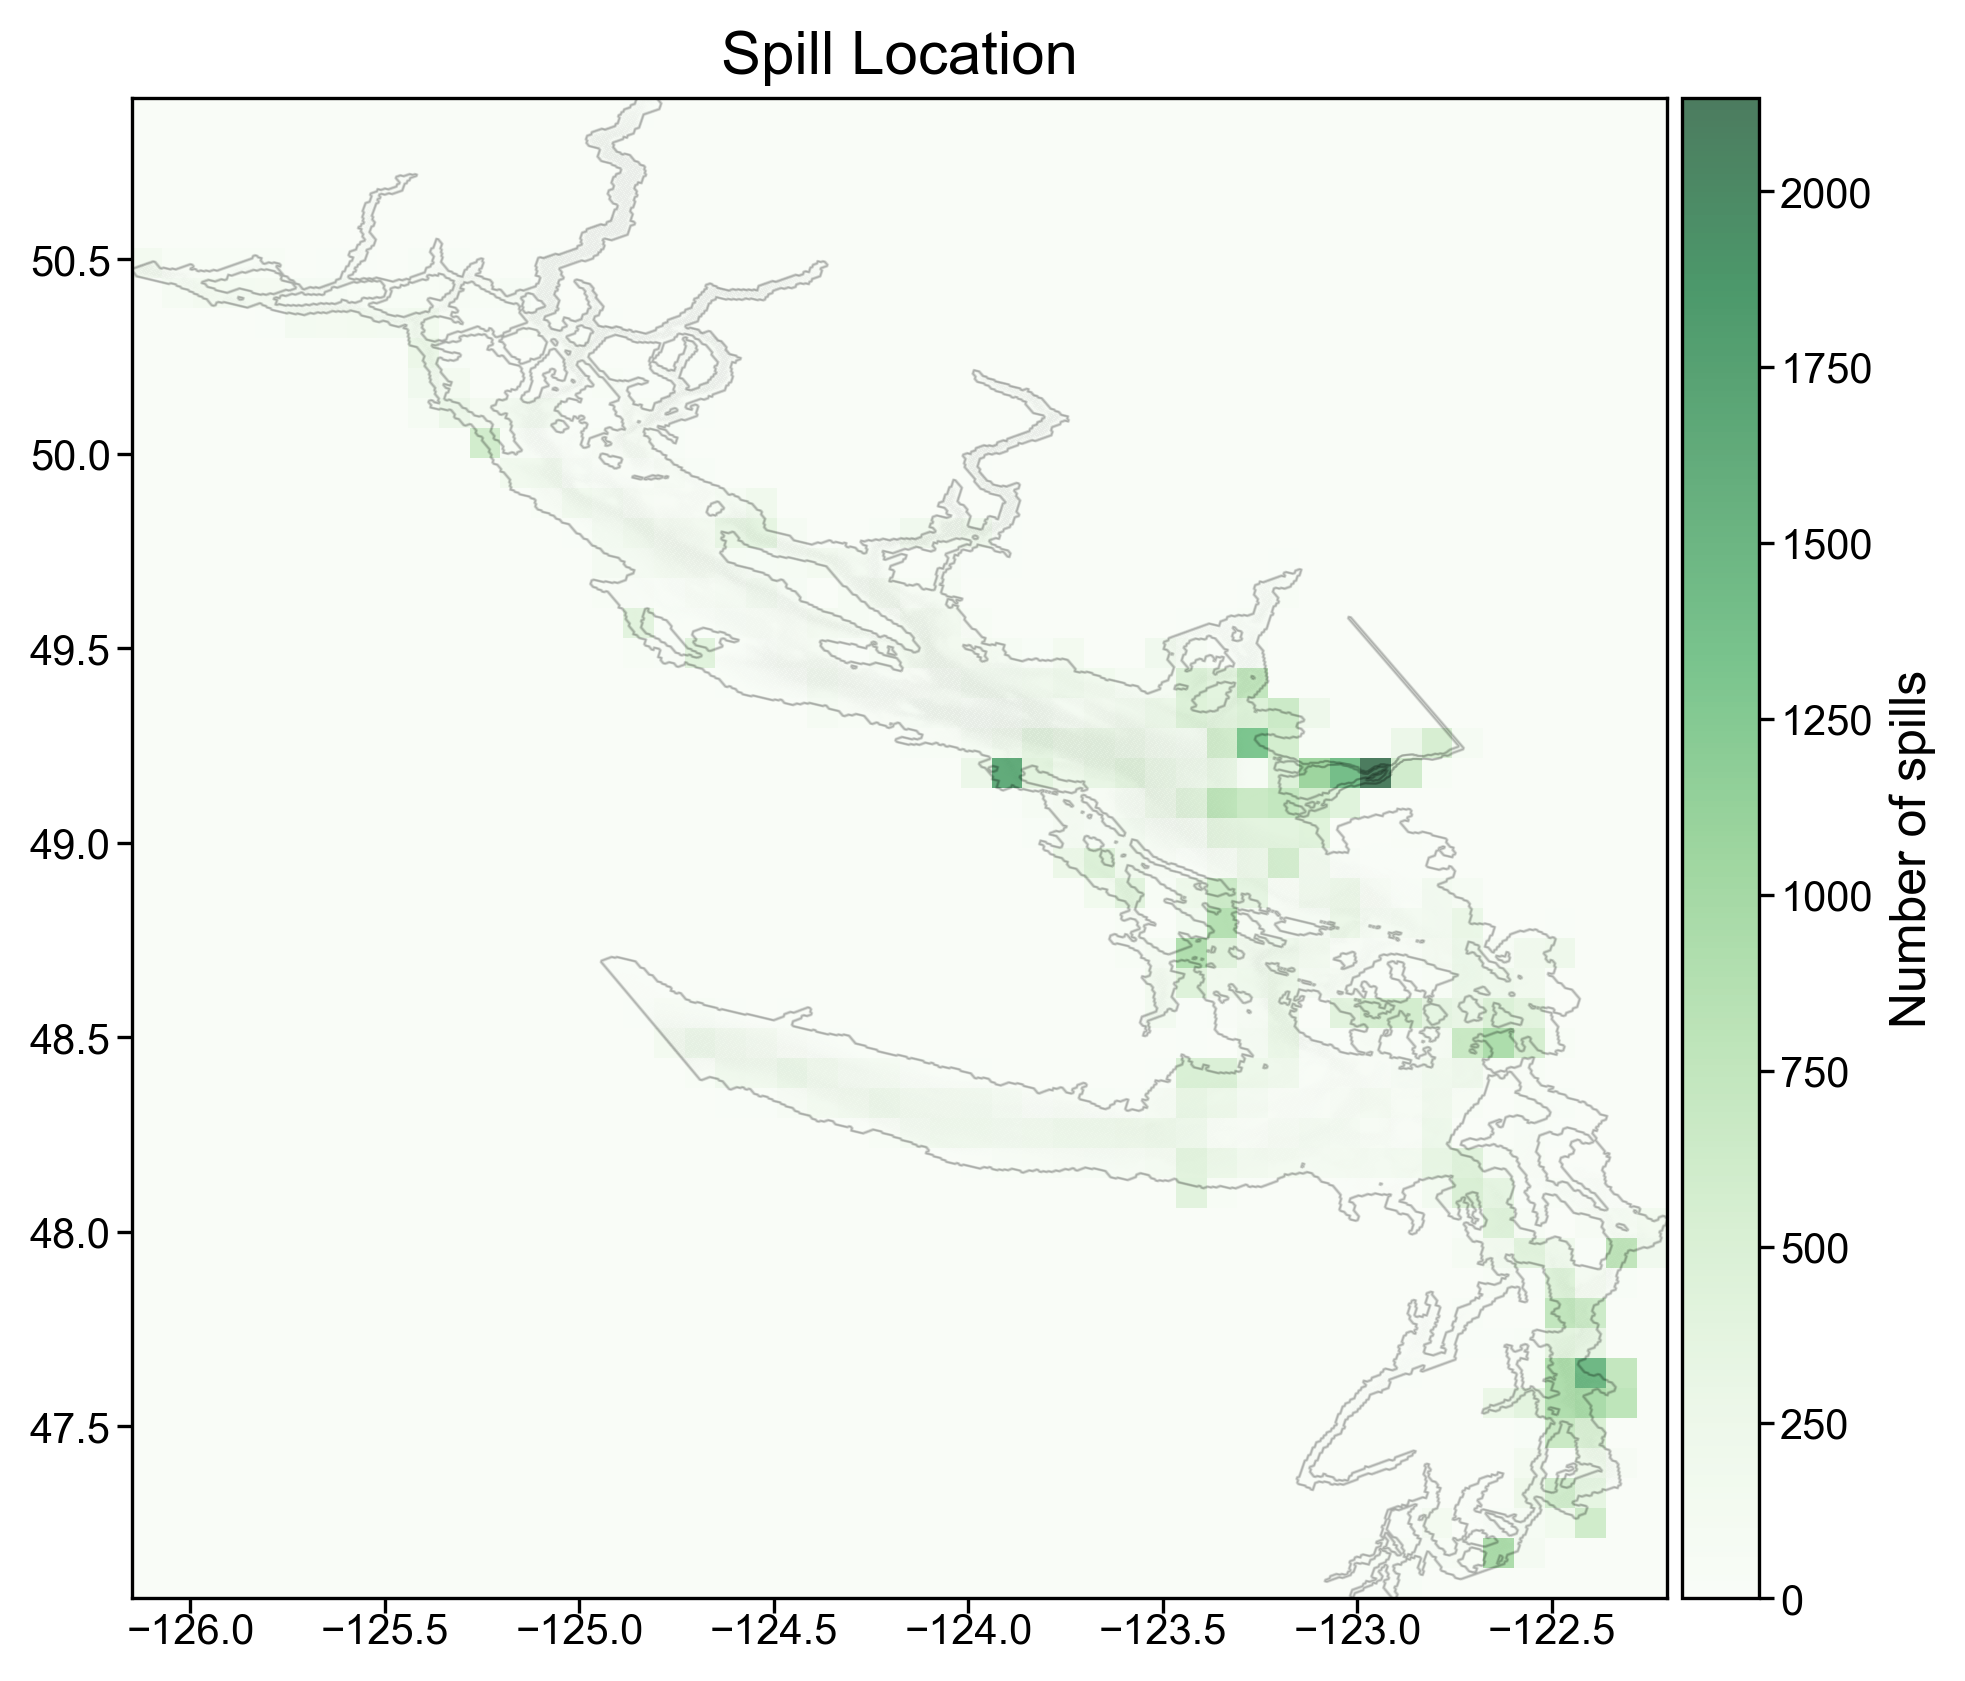

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pcolormesh(
    bathy.nav_lon, 
    bathy.nav_lat, 
    bathy.Bathymetry, cmap='Greys', alpha=.1)
ax.contour(
    bathy.nav_lon, 
    bathy.nav_lat,
    tmask, alpha=0.05,colors='k',linewidths =.5)

h = ax.hist2d(
    df_combined.spill_lon, 
    df_combined.spill_lat, 
    alpha=0.7, cmap='Greens', bins=50);
ax.set_aspect(1)
ax.set_title('Spill Location');
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(h[3], cax=cax)
cb.set_label('Number of spills')